# Spyglass access tutorial
This tutorial demonstrates how to access and explore data from the Kind Lab datasets using Spyglass.

- Connect to the Spyglass database using DataJoint
- Query session, subject, and experimental metadata
- Access digital I/O events, task epochs, and electrode information
- Work with NWB files through the Spyglass framework

The example focuses on a specific experimental session (Baseline-tone-flash-hab) from subject Rat-1021.

---

## Import Required Libraries

In [7]:
from pathlib import Path
import datajoint as dj
dj.conn(use_tls=False)  # configurable in config using [datababse.use_tls]
dj_local_conf_path = "/home/alessandra/CatalystNeuro/kind-lab-to-nwb/dj_local_conf.json"
dj.config.load(dj_local_conf_path)  # load config for database connection info
# to prevent needing to load before import, consider saving the config
dj.config.save_global()  # default loaded for anywhere on the system
dj.config.save_local()  # loaded when running a script from this directory

# spyglass.common has the most frequently used tables
import spyglass.common as sgc  # this import connects to the database
# spyglass.data_import has tools for inserting NWB files into the database
import spyglass.data_import as sgi
# LFP Imports
import spyglass.lfp as sglfp
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename, get_nwb_file

from kind_lab_to_nwb.spyglass_utils import AnnotatedEvents

# Visualization
import matplotlib.pyplot as plt
# Configure matplotlib
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

[2026-01-15 16:57:37,252][INFO]: DataJoint is configured from /home/alessandra/CatalystNeuro/kind-lab-to-nwb/dj_local_conf.json


## Spyglass database

In [8]:
sgc.Session()

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
sub-1072-Grin2b(6)_ses-OR-HabD1_.nwb,1072-Grin2b(6),University of Edinburgh,Kind,OR_HabD1-2023-09-11,Experimental Day 1. Individual rat placed in arena for 10 min habituation,2023-09-11 13:58:59,2023-09-11 13:58:59,"This experiment is part of the Rat Behavioural Phenotyping Pipeline Methodologies https://sidb.org.uk/facilities/rat-behavioural-phenotyping-pipeline/. As an initial effort to characterize the rat lines, these models are being behaviorally phenotyped at SIDB. Rat models are phenotyped according to a rigorous pipeline that assesses behaviours relevant to autism with intellectual disability, such as social and motor skills, and learning and sensory processing. Different cohorts of rats are run through different subsets of tasks to overcome potential order effects on behaviours and to limit the number of tasks each animal is put through. This experiment investigated object recognition memory in different rat models (Arid1b: https://rgd.mcw.edu/rgdweb/report/strain/main.html?id=14394518, Grin2b: https://rgd.mcw.edu/rgdweb/report/strain/main.html?id=14394515, Scn2a: https://rgd.mcw.edu/rgdweb/report/strain/main.html?id=25394530). The experimenter was blind to genotype throughout the experiment and watched the trials on a screen from outside the testing room. The task utilized a custom-built arena (60x60 cm) with black laminated wood walls and grey lino floor. Rats underwent habituation (3 days, 10 min each) followed by sample and test trials to assess their ability to recognize novel objects. The protocol included sample trials (15 min with two identical objects) and test trials (3 min) with one novel object. Both short-term (5 min delay) and long-term (24 hr delay) memory were assessed. Object exploration was recorded via CCTV camera and manually scored using BORIS software."
sub-1073-Grin2b(6)_ses-OLM-HabD2_.nwb,1073-Grin2b(6),University of Edinburgh,Kind,OLM_HabD2-2023-08-22,Experimental Day 2. Individual rat placed in arena for 10 min habituation,2023-08-22 14:22:37,2023-08-22 14:22:37,"This experiment is part of the Rat Behavioural Phenotyping Pipeline Methodologies https://sidb.org.uk/facilities/rat-behavioural-phenotyping-pipeline/. As an initial effort to characterize the rat lines, these models are being behaviorally phenotyped at SIDB. Rat models are phenotyped according to a rigorous pipeline that assesses behaviours relevant to autism with intellectual disability, such as social and motor skills, and learning and sensory processing. Different cohorts of rats are run through different subsets of tasks to overcome potential order effects on behaviours and to limit the number of tasks each animal is put through. This experiment investigated object location memory in different rat models (Arid1b: https://rgd.mcw.edu/rgdweb/report/strain/main.html?id=14394518, Grin2b: https://rgd.mcw.edu/rgdweb/report/strain/main.html?id=14394515, Scn2a: https://rgd.mcw.edu/rgdweb/report/strain/main.html?id=25394530). The experimenter was blind to genotype throughout the experiment and watched the trials on a screen from outside the testing room. The task utilized two custom-built arenas (60x60 cm) with different wall colors and bedding. Rats underwent habituation followed by sample and test trials to assess their ability to detect object location changes. The protocol included group habituation (10 min), individual habituation (2 days, 10 min each), sample trials (15 min with two identical objects), and test trials (3 min) with one object moved to a new location. Both short-term (5 min delay) and long-term (1 hr delay) memory were assessed. Object exploration was recorded via CCTV camera and manually scored using BORIS software."
sub-1275-Grin2b(10)_ses-AFC-2-HabD2_.nwb,1275_Grin2b(10),University of Edinburgh,Kind,AFC_2_HabD2,"Experimental Day 2. Habituation to

In [ ]:
# Load session data
session_id = "Baseline-tone-flash-hab"
subject_id = "Rat-1021"
nwb_file_name = get_nwb_copy_filename(f"sub-{subject_id}_ses-{session_id}.nwb")
sgc.Session & {'nwb_file_name': nwb_file_name}

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
sub-Rat-1021_ses-Baseline-tone-flash-hab_.nwb,Rat_1021,University of Edinburgh,Kind,Baseline_tone_flash_hab,"Experimental day 4. Session to probe CS (blue led flash) pre-exposure without fear. On experimental day 4, recordings were made while a subset of 19 rats were pre-exposed to 10s of blue flashing light (5 Hz 110 lux flashes, 50 / 50 duty cycle) of the same properties as that used for subsequent conditioning and recall, the purpose of this exposure was to test for behavioral and LFP responses to the sensory stimuli prior to association with a footshock. Pre-exposure was followed immediately by conditioning.",2020-09-24 14:07:01,2020-09-24 14:07:01,"The experiment investigated fear conditioning in male wild-type and Syngap1+/Delta-GAP rats (n=31, ages 3-6 months). Recordings included Local Field Potentials (LFP), electroencephalogram (EEG), head-mounted accelerometer data, and behavioral video recordings across five experimental days. The protocol involved context habituation, seizure screening, and a fear conditioning paradigm where rats were exposed to blue flashing light (5 Hz, 110 lux) paired with foot shocks. Data were collected using OpenEphys software and a 16-channel Intan digitizing head stage. Behavioral paradigm triggers were managed using FreezeFrame software, and behavioral cameras recorded rat movements throughout the experimental sessions. The experimental design allowed for assessing neural responses, seizure occurrence, and fear learning in these genetic variants."


In [ ]:

sgc.Subject() & {'subject_id': "Rat_1021"}

subject_id,age,description,genotype,sex,species
Rat_1021,P12W/P24W,"Subjects were Evans-SGem2/PWC were genotyped by PCR. This study used male rats (n=31, 16 wild-types and 15 Syngap+/âˆ†-GAP) bred in-house and maintained in standard housing on a 12h/12h light dark with ad libitum access to water and food. Experimental animals were weaned from their dams postnatal day 22 (P22D) and housed with their WT littermates, 2-4 animals per cage. Genetically modified males and WT littermates ranging from 3 to 6 months of age were used for all experiments.",WT,M,Rattus norvegicus


In [37]:
eeg_series = (sgc.Raw & {'nwb_file_name': nwb_file_name}).fetch_nwb()[0]['raw']

In [ ]:
lfp_series = (sglfp.ImportedLFP & {"nwb_file_name": nwb_file_name}).fetch_nwb()[0]["lfp"]

In [41]:
sgc.DIOEvents & {"nwb_file_name": nwb_file_name}

nwb_file_name name of the NWB file,dio_event_name the name assigned to this DIO event,dio_object_id the object id of the data in the NWB file,interval_list_name descriptive name of this interval list
sub-Rat-1021_ses-Baseline-tone-flash-hab_.nwb,TTL_audio_trigger,dfdb22b8-4061-41d1-bfa5-488b887ea83c,raw data valid times
sub-Rat-1021_ses-Baseline-tone-flash-hab_.nwb,TTL_LED_trigger,294bc6e8-917e-46c1-9eaa-fb72769573e0,raw data valid times


In [ ]:
audio_trigger = (sgc.DIOEvents & {"nwb_file_name": nwb_file_name, "dio_event_name": "TTL_audio_trigger"}).fetch_nwb()[0][
    "dio"
]

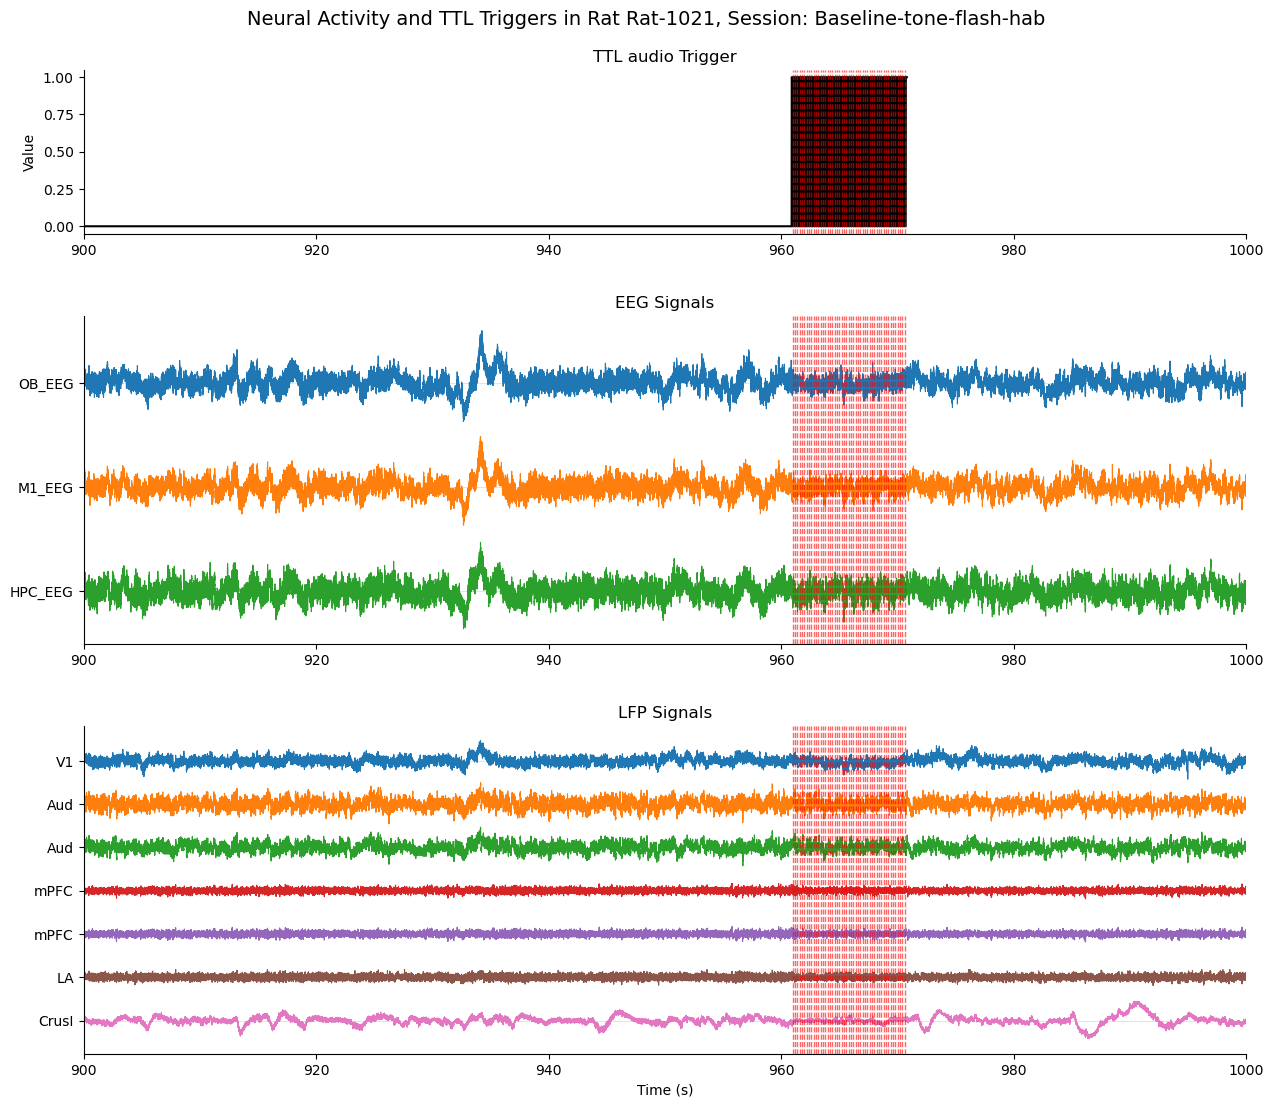

In [ ]:
import numpy as np
from matplotlib.gridspec import GridSpec

import matplotlib.pyplot as plt

# Define a common time window to show across all signals
start_time = 900  # seconds
end_time = 1000.0  # seconds

# Create figure with GridSpec for flexible layout
fig = plt.figure(figsize=(15, 12))
gs = GridSpec(3, 1, height_ratios=[1, 2, 2], hspace=0.3)

# Get indices for the time window for each dataset
ttl_timestamps = audio_trigger.get_timestamps()
ttl_start_idx = (
    np.where(ttl_timestamps >= start_time)[0][0] if len(np.where(ttl_timestamps >= start_time)[0]) > 0 else 0
)
ttl_end_idx = (
    np.where(ttl_timestamps <= end_time)[0][-1]
    if len(np.where(ttl_timestamps <= end_time)[0]) > 0
    else len(ttl_timestamps) - 1
)

eeg_timestamps = eeg_series.get_timestamps()
eeg_start_idx = (
    np.where(eeg_timestamps >= start_time)[0][0] if len(np.where(eeg_timestamps >= start_time)[0]) > 0 else 0
)
eeg_end_idx = (
    np.where(eeg_timestamps <= end_time)[0][-1]
    if len(np.where(eeg_timestamps <= end_time)[0]) > 0
    else len(eeg_timestamps) - 1
)

lfp_timestamps = lfp_series.get_timestamps()
lfp_start_idx = (
    np.where(lfp_timestamps >= start_time)[0][0] if len(np.where(lfp_timestamps >= start_time)[0]) > 0 else 0
)
lfp_end_idx = (
    np.where(lfp_timestamps <= end_time)[0][-1]
    if len(np.where(lfp_timestamps <= end_time)[0]) > 0
    else len(lfp_timestamps) - 1
)

# 1. TTL Trigger Plot
ax1 = fig.add_subplot(gs[0])
ttl_data = np.array(audio_trigger.data[ttl_start_idx:ttl_end_idx])
ttl_times = ttl_timestamps[ttl_start_idx:ttl_end_idx]
ax1.plot(ttl_times, ttl_data, "k-", linewidth=1.5)
ax1.set_title("TTL audio Trigger", fontsize=12)
ax1.set_ylabel("Value")
ax1.set_xlim(start_time, end_time)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

# 2. EEG Signals Plot
ax2 = fig.add_subplot(gs[1])
eeg_data = np.array(eeg_series.data[eeg_start_idx:eeg_end_idx])
eeg_times = eeg_timestamps[eeg_start_idx:eeg_end_idx]

# Calculate offset for stacking EEG channels
eeg_offset = np.max(np.abs(eeg_data)) * 2
eeg_y_positions = []

# Plot EEG signals
for i in range(eeg_data.shape[1]):
    y_offset = -i * eeg_offset
    ax2.axhline(y=y_offset, color="gray", linestyle="-", alpha=0.3, linewidth=0.5)
    ax2.plot(eeg_times, eeg_data[:, i] + y_offset, linewidth=0.8)
    eeg_y_positions.append(y_offset)

# Add EEG labels and styling
ax2.set_yticks(eeg_y_positions)
eeg_labels = eeg_series.electrodes.to_dataframe()["group_name"]
eeg_labels = eeg_labels.str.replace("_electrode_group", "")
ax2.set_yticklabels(eeg_labels, fontsize=10)
ax2.set_title("EEG Signals", fontsize=12)
ax2.set_xlim(start_time, end_time)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# 3. LFP Signals Plot
ax3 = fig.add_subplot(gs[2])
lfp_data = np.array(lfp_series.data[lfp_start_idx:lfp_end_idx])
lfp_times = lfp_timestamps[lfp_start_idx:lfp_end_idx]

# Calculate offset for stacking LFP channels
lfp_offset = float(np.max(np.abs(lfp_data)) * 2)
lfp_y_positions = []

# Plot LFP signals
for i in range(lfp_data.shape[1]):
    y_offset = -i * lfp_offset
    ax3.axhline(y=y_offset, color="gray", linestyle="-", alpha=0.3, linewidth=0.5)
    ax3.plot(lfp_times, lfp_data[:, i] + y_offset, linewidth=0.8)
    lfp_y_positions.append(y_offset)

# Add LFP labels and styling
ax3.set_yticks(lfp_y_positions)
lfp_labels = lfp_series.electrodes.to_dataframe()["group_name"]
lfp_labels = lfp_labels.str.replace("_LFP_electrode_group", "")
ax3.set_yticklabels(lfp_labels, fontsize=10)
ax3.set_title("LFP Signals", fontsize=12)
ax3.set_xlabel("Time (s)", fontsize=10)
ax3.set_xlim(start_time, end_time)
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)

# Add vertical lines at TTL high-to-low transitions to see stimulus alignment
high_indices = np.where(np.diff(ttl_data) < 0)[0]
for idx in high_indices:
    transition_time = ttl_times[idx]
    ax1.axvline(x=transition_time, color="r", linestyle="--", alpha=0.6, linewidth=1)
    ax2.axvline(x=transition_time, color="r", linestyle="--", alpha=0.6, linewidth=1)
    ax3.axvline(x=transition_time, color="r", linestyle="--", alpha=0.6, linewidth=1)

plt.suptitle(f"Neural Activity and TTL Triggers in Rat {subject_id}, Session: {session_id}", fontsize=14)
# plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

In [13]:
sgc.TaskEpoch & {"nwb_file_name": nwb_file_name}

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),task_name,camera_name,interval_list_name descriptive name of this interval list,task_environment the environment the animal was in,camera_names list of keys corresponding to entry in CameraDevice
sub-Rat-1021_ses-Baseline-tone-flash-hab_.nwb,1,baseline_tone_flash_habituation,None,01,None,=BLOB=


In [14]:
sgc.ElectrodeGroup & {"nwb_file_name": nwb_file_name}

nwb_file_name name of the NWB file,electrode_group_name electrode group name from NWBFile,region_id,probe_id a unique ID for this probe & dynamic config,description description of electrode group,target_hemisphere
sub-Rat-1021_ses-Baseline-tone-flash-hab_.nwb,Aud_LFP_electrode_group,8,Intan C3334,LFP signal recorded from the Auditory Cortex.,Right
sub-Rat-1021_ses-Baseline-tone-flash-hab_.nwb,bad_electrode_group,7,Intan C3334,Bad electrodes group.,Right
sub-Rat-1021_ses-Baseline-tone-flash-hab_.nwb,CrusI_LFP_electrode_group,9,Intan C3334,LFP signal recorded from the Crus I.,Right
sub-Rat-1021_ses-Baseline-tone-flash-hab_.nwb,HPC_EEG_electrode_group,4,Intan C3334,EEG signal recorded from the Hippocampus.,Right
sub-Rat-1021_ses-Baseline-tone-flash-hab_.nwb,LA_LFP_electrode_group,12,Intan C3334,LFP signal recorded from the Lateral Amygdala.,Right
sub-Rat-1021_ses-Baseline-tone-flash-hab_.nwb,M1_EEG_electrode_group,5,Intan C3334,EEG signal recorded from the Motor Cortex.,Right
sub-Rat-1021_ses-Baseline-tone-flash-hab_.nwb,mPFC_LFP_electrode_group,11,Intan C3334,LFP signal recorded from the Medial Prefrontal Cortex (Infralimbic cortex).,Right
sub-Rat-1021_ses-Baseline-tone-flash-hab_.nwb,OB_EEG_electrode_group,6,Intan C3334,EEG signal recorded from the Olfactory Bulb.,Right
sub-Rat-1021_ses-Baseline-tone-flash-hab_.nwb,V1_LFP_electrode_group,10,Intan C3334,LFP signal recorded from the Primary Visual Cortex.,Right


In [15]:
sgc.Electrode & {"nwb_file_name": nwb_file_name}

nwb_file_name name of the NWB file,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode,probe_id a unique ID for this probe & dynamic config,probe_shank unique shank number within probe.,"probe_electrode electrode ID, output from acquisition",region_id,name unique label for each contact,original_reference_electrode the configured reference electrode for this electrode,x the x coordinate of the electrode position in the brain,y the y coordinate of the electrode position in the brain,z the z coordinate of the electrode position in the brain,filtering description of the signal filtering,impedance electrode impedance,"bad_channel if electrode is ""good"" or ""bad"" as observed during recording",x_warped x coordinate of electrode position warped to common template brain,y_warped y coordinate of electrode position warped to common template brain,z_warped z coordinate of electrode position warped to common template brain,contacts label of electrode contacts used for a bipolar signal - current workaround
sub-Rat-1021_ses-Baseline-tone-flash-hab_.nwb,Aud_LFP_electrode_group,2,Intan C3334,2,2,8,2,2,nan,nan,nan,unfiltered,nan,False,0.0,0.0,0.0,
sub-Rat-1021_ses-Baseline-tone-flash-hab_.nwb,Aud_LFP_electrode_group,3,Intan C3334,3,3,8,3,3,nan,nan,nan,unfiltered,nan,False,0.0,0.0,0.0,
sub-Rat-1021_ses-Baseline-tone-flash-hab_.nwb,bad_electrode_group,1,Intan C3334,1,1,7,1,1,nan,nan,nan,unfiltered,nan,True,0.0,0.0,0.0,
sub-Rat-1021_ses-Baseline-tone-flash-hab_.nwb,bad_electrode_group,4,Intan C3334,4,4,7,4,4,nan,nan,nan,unfiltered,nan,True,0.0,0.0,0.0,
sub-Rat-1021_ses-Baseline-tone-flash-hab_.nwb,bad_electrode_group,7,Intan C3334,7,7,7,7,7,nan,nan,nan,unfiltered,nan,True,0.0,0.0,0.0,
sub-Rat-1021_ses-Baseline-tone-flash-hab_.nwb,bad_electrode_group,13,Intan C3334,13,13,7,13,13,nan,nan,nan,unfiltered,nan,True,0.0,0.0,0.0,
sub-Rat-1021_ses-Baseline-tone-flash-hab_.nwb,bad_electrode_group,14,Intan C3334,14,14,7,14,14,nan,nan,nan,unfiltered,nan,True,0.0,0.0,0.0,
sub-Rat-1021_ses-Baseline-tone-flash-hab_.nwb,bad_electrode_group,15,Intan C3334,15,15,7,15,15,nan,nan,nan,unfiltered,nan,True,0.0,0.0,0.0,
sub-Rat-1021_ses-Baseline-tone-flash-hab_.nwb,CrusI_LFP_electrode_group,12,Intan C3334,12,12,9,12,12,nan,nan,nan,unfiltered,nan,False,0.0,0.0,0.0,
sub-Rat-1021_ses-Baseline-tone-flash-hab_.nwb,HPC_EEG_electrode_group,11,Intan C3334,11,11,4,11,11,nan,nan,nan,unfiltered,nan,False,0.0,0.0,0.0,
